In [1]:
from scripts.graph_utils import read_graph, read_edge_list
import networkx as nx
import pandas as pd
import numpy as np
from stellargraph.core.graph import StellarGraph
from stellargraph.mapper.full_batch_generators import FullBatchNodeGenerator
from stellargraph.layer import GCN
import stellargraph as sg
from stellargraph.mapper.sampled_node_generators import GraphSAGENodeGenerator
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification, link_regression

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Model, optimizers, losses, metrics

from stellargraph.data import EdgeSplitter

from stellargraph.mapper import HinSAGELinkGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
old_edgelist_filepath ='data/reviews_edgelist_old.txt'
new_edgelist_filepath ='data/reviews_edgelist_new.txt'

books_features_old = "data/books_description_reviews_features_old.npy"
books_features_new = "data/books_description_reviews_features_new.npy"

users_features_old = "data/user_reviewed_books_description_and_reviews_features_old.npy"
users_features_new = "data/user_reviewed_books_description_and_reviews_features_new.npy"

train_graph, nodes, feature_names = read_graph(old_edgelist_filepath,books_features_old, users_features_old, with_weights=True,similar_books_edges=True)
test_graph, nodes, feature_names = read_graph(new_edgelist_filepath,books_features_new, users_features_new, with_weights=True,similar_books_edges=True)

edges_with_ratings = pd.read_csv("data/reviews_edgelist_old.txt",delimiter="\t", names=["user_id","book_id","rating"])
edges_with_ratings["book_id"] = edges_with_ratings["book_id"].astype(str)
stellar_graph = StellarGraph.from_networkx(train_graph, node_features="feature", edge_type_default="rating")

In [3]:
print(stellar_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 122803, Edges: 530477

 Node types:
  user: [77562]
    Features: float32 vector, length 384
    Edge types: user-rating->book
  book: [45241]
    Features: float32 vector, length 384
    Edge types: book-rating->user, book-similar->book

 Edge types:
    book-rating->user: [458056]
        Weights: range=[0, 5], mean=3.88684, std=1.18253
        Features: none
    book-similar->book: [72421]
        Weights: all 1 (default)
        Features: none


In [4]:
batch_size = 200
epochs = 3
# Use 80% of edges for training, the rest for validation & testing:
train_size = 0.8
val_size = 0.2

In [5]:
edges_train, edges_val = model_selection.train_test_split(
    edges_with_ratings, train_size=train_size, test_size=val_size
)

# edges_test, edges_val = model_selection.train_test_split(
#     edges_test, train_size=0.5, test_size=0.5
# )

edgelist_train = list(edges_train[["user_id", "book_id"]].itertuples(index=False))
edgelist_val = list(edges_val[["user_id", "book_id"]].itertuples(index=False))
# edgelist_test = list(edges_test[["user_id", "book_id"]].itertuples(index=False))

labels_train = list(edges_train["rating"].values)
labels_val = list(edges_val["rating"].values)
# labels_test = list(edges_test["rating"].values)

In [6]:
num_samples = [10, 5]

In [7]:
generator = HinSAGELinkGenerator(
    stellar_graph, batch_size, num_samples, head_node_types=["user", "book"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
val_gen = generator.flow(edgelist_val, labels_val)
# test_gen = generator.flow(edgelist_test, labels_test)

In [8]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [9]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

In [10]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="mul")(x_out)

link_regression: using 'mul' method to combine node embeddings into edge embeddings


In [11]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [12]:
# model.summary()

In [13]:
# Specify the number of workers to use for model training
num_workers = 4

In [14]:
# get 20% from the edges for testing
test_size = len(edges_val)
print(test_size)
test_edges_with_ratings = pd.read_csv("data/reviews_edgelist_new.txt",delimiter="\t", names=["user_id","book_id","rating"])
test_edges_with_ratings["book_id"] = test_edges_with_ratings["book_id"].astype(str)

edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, test_size=test_size
)
print(len(edges_test))
edgelist_test = list(edges_test[["user_id", "book_id"]].itertuples(index=False))
labels_test = list(edges_test["rating"].values)


test_gen = generator.flow(edgelist_test, labels_test)
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

92622
92622
464/464 [==============================] - 393s 847ms/step - loss: 16.4297 - root_mean_square_error: 4.0519 - mean_absolute_error: 3.8769
Untrained model's Test Evaluation:
	loss: 16.4297
	root_mean_square_error: 4.0519
	mean_absolute_error: 3.8769


In [15]:
es = EarlyStopping(monitor='val_root_mean_square_error', mode='min', verbose=1, patience=4)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
    callbacks=[es]
)

Epoch 1/3
1853/1853 [==============================] - 2873s 2s/step - loss: 1.7185 - root_mean_square_error: 1.2492 - mean_absolute_error: 0.9740 - val_loss: 1.2953 - val_root_mean_square_error: 1.1349 - val_mean_absolute_error: 0.8404
Epoch 2/3
1853/1853 [==============================] - 2341s 1s/step - loss: 1.2921 - root_mean_square_error: 1.1336 - mean_absolute_error: 0.8531 - val_loss: 1.2767 - val_root_mean_square_error: 1.1269 - val_mean_absolute_error: 0.8388
Epoch 3/3
1853/1853 [==============================] - 2326s 1s/step - loss: 1.2727 - root_mean_square_error: 1.1249 - mean_absolute_error: 0.8471 - val_loss: 1.2563 - val_root_mean_square_error: 1.1178 - val_mean_absolute_error: 0.8431


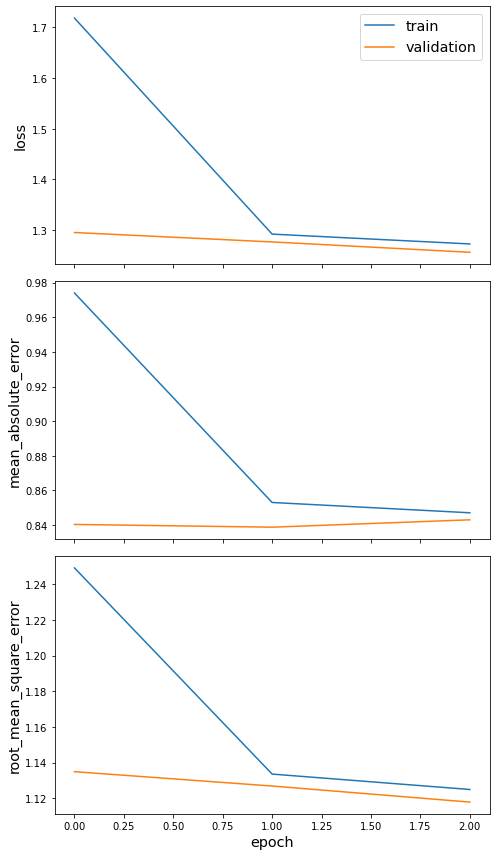

In [16]:
sg.utils.plot_history(history)

In [17]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

464/464 [==============================] - 290s 624ms/step - loss: 1.2606 - root_mean_square_error: 1.1204 - mean_absolute_error: 0.8443 - loss: 1.2606 - root_mean_square_error: 1.1204 - mean_absolute_error: 0.84
Test Evaluation:
	loss: 1.2606
	root_mean_square_error: 1.1204
	mean_absolute_error: 0.8443


In [18]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.186013232446381
	mean_absolute_error =  0.8843760497316077

Model Test set metrics:
	root_mean_square_error =  1.1232399996122104
	mean_absolute_error =  0.8449366579476961


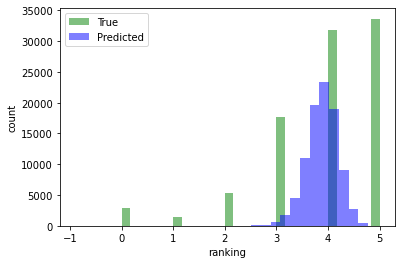

In [19]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()